## Image differencing tests  - part 2


In [13]:
%matplotlib notebook
import numpy as np
import numpy.random
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.colors
from lsst.meas.algorithms import KernelPsf

verbose = 1
# Development copy of lsst/ip/diffim/tests/test_subtractExposures.py
%run -n -i "test_image_subtraction2.py"

In [14]:
T = SubtractionTest()

All good case.

In [15]:
spsf = 3.3
tpsf = 2.2
T.setUpImages(spsf=spsf, tpsf=tpsf)
T.runSubtractionSimple()

Science PSF: [3.3, 3.3] 0.0
Template PSF: [2.2, 2.2] 0.0
2.459674775249768
Offset: [0.0, 0.0]
[   9.95070683  -36.37229591  106.13536739  107.26689312  429.16764686
  -39.21874504  316.13600328  101.0496909   106.40247316  280.42037882
 -152.31783235  273.70911988 -429.09699359  223.80216187 -215.75645494
 -254.27530438  294.98325018   73.39712067  459.38832487 -224.54433346] [ 360.70735214  366.32768347  452.24698704  234.21744645  485.84750432
  404.61182613  259.30138546  -41.91803444 -298.35290338  323.37569379
 -113.32859789  269.31334127 -398.7496776  -441.530006    441.77008407
  284.73326229  405.25138817  240.89942717  111.15435631  266.48324051]
PSF y spatial-variation: -0.0 -0.0


Now see whether this solution has the expected radius

In [20]:
kpsf = KernelPsf(T.results1.psfMatchingKernel)
sol_sig = kpsf.computeShape().getDeterminantRadius()  # sigma
print (f"Solution sigma:{sol_sig:.3f}")
theo_sig = np.sqrt(spsf*spsf - tpsf * tpsf)
print (f"Theoretical matching sigma:{theo_sig:.3f}")

Solution sigma:2.463
Theoretical matching sigma:2.460


Kernel solution at the center of the image

(minimum=(0, 0), maximum=(1023, 1023))


<IPython.core.display.Javascript object>


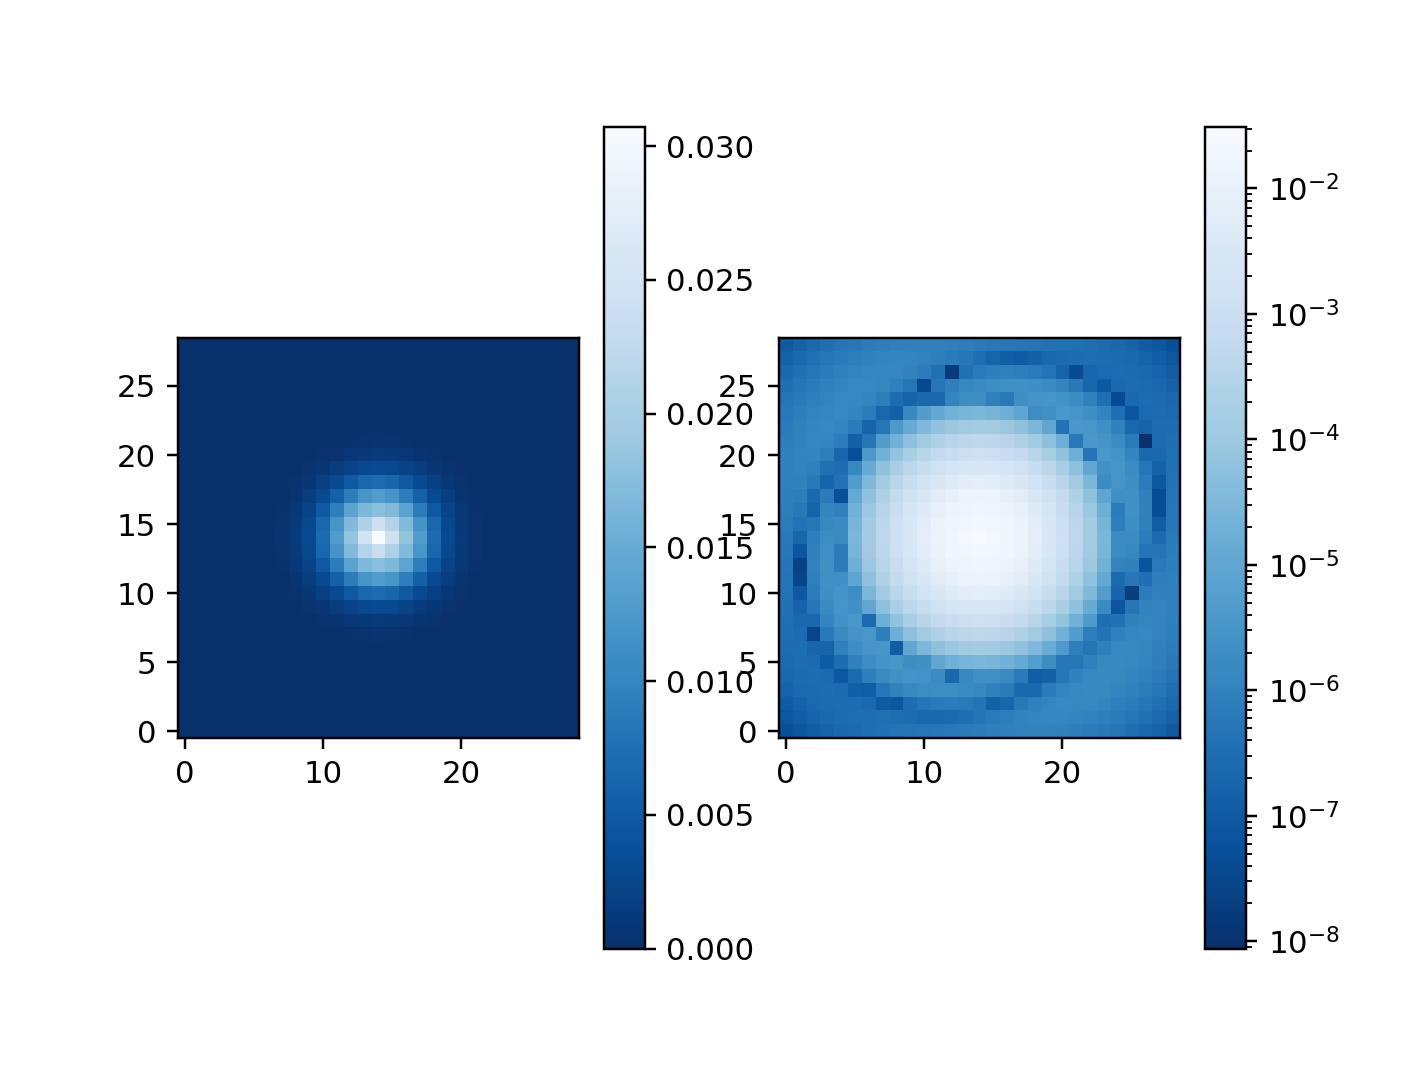

In [6]:

kImg = afwImage.ImageD(T.results1.psfMatchingKernel.getDimensions())
print(T.results1.subtractedExposure.getBBox())
T.results1.psfMatchingKernel.computeImage(kImg,False,512,512)

# Normal and log-plot of kernel solution
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
kArr = kImg.getArray()
cs = ax.imshow(kArr,origin='bottom',cmap='Blues_r')
fig.colorbar(cs)
ax = fig.add_subplot(1,2,2)
cs = ax.imshow(np.abs(kArr)+1e-10,origin='bottom',cmap='Blues_r',norm=matplotlib.colors.LogNorm())
fig.colorbar(cs)

### TODO:

* repeat with decorrelation afterburner turned on
* move kernel plotting code into included scripts file
* repeat with close matching case

Close matching case, no distortion, no offset

In [8]:
np.sqrt(2.2**2 - 2.1**2)

0.6557438524302005

In [9]:
T.setUpImages(spsf=2.2,tpsf=2.1)
T.runSubtractionSimple()

Science PSF: [2.2, 2.2] 0.0
Template PSF: [2.1, 2.1] 0.0
0.6557438524302005
Offset: [0.0, 0.0]
[   9.95070683  -36.37229591  106.13536739  107.26689312  429.16764686
  -39.21874504  316.13600328  101.0496909   106.40247316  280.42037882
 -152.31783235  273.70911988 -429.09699359  223.80216187 -215.75645494
 -254.27530438  294.98325018   73.39712067  459.38832487 -224.54433346] [ 360.70735214  366.32768347  452.24698704  234.21744645  485.84750432
  404.61182613  259.30138546  -41.91803444 -298.35290338  323.37569379
 -113.32859789  269.31334127 -398.7496776  -441.530006    441.77008407
  284.73326229  405.25138817  240.89942717  111.15435631  266.48324051]
PSF y spatial-variation: -0.0 -0.0


<IPython.core.display.Javascript object>


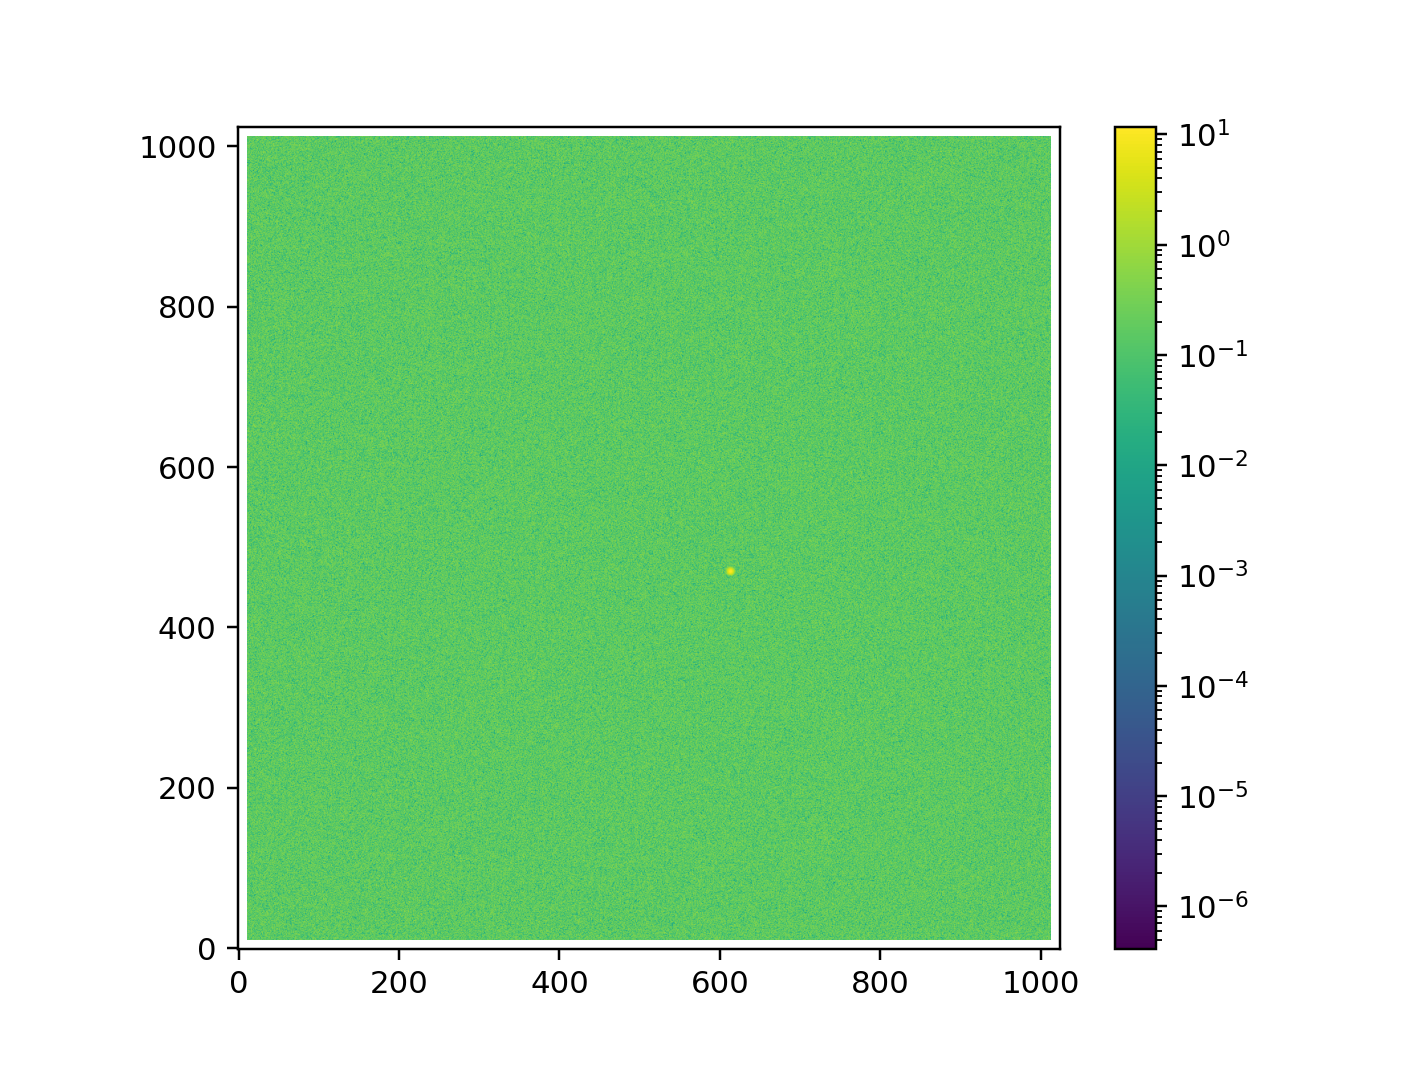

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
subsArr = T.results1.subtractedExposure.getMaskedImage().getImage().getArray()
cs = ax.imshow(np.abs(subsArr),origin='bottom',norm=matplotlib.colors.LogNorm())
fig.colorbar(cs)

(minimum=(0, 0), maximum=(1023, 1023))


<IPython.core.display.Javascript object>


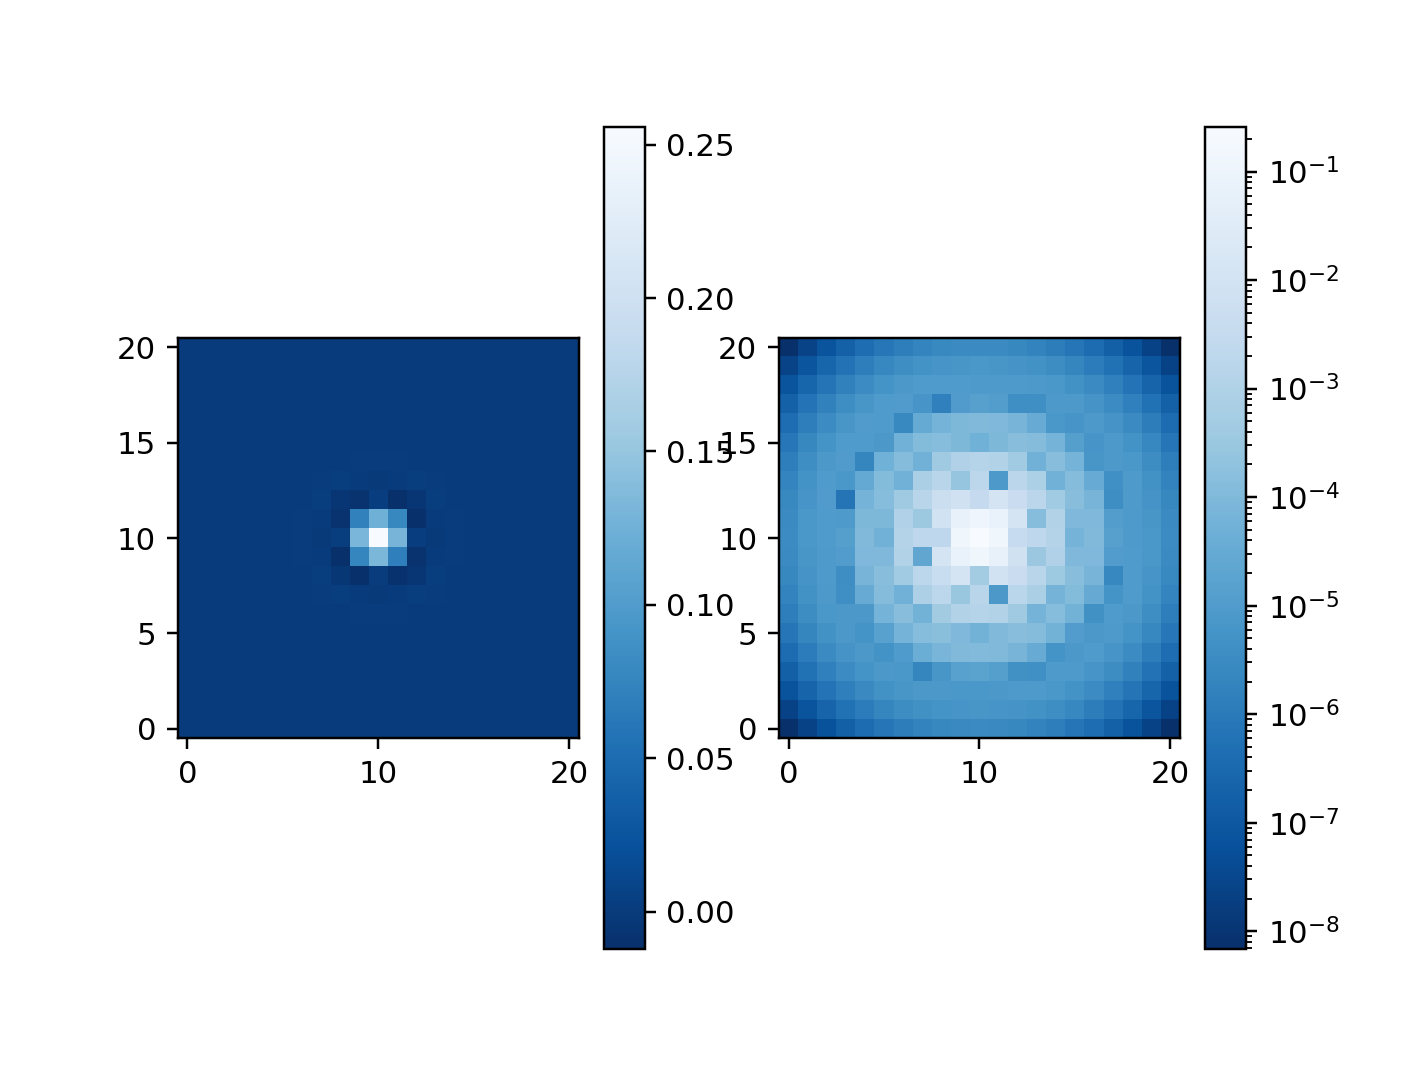

In [11]:
#T.results1.psfMatchingKernel.computeImage(512,512)
kImg = afwImage.ImageD(T.results1.psfMatchingKernel.getDimensions())
print(T.results1.subtractedExposure.getBBox())
T.results1.psfMatchingKernel.computeImage(kImg,False,512,512)

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
kArr = kImg.getArray()
cs = ax.imshow(kArr,origin='bottom',cmap='Blues_r')
fig.colorbar(cs)

ax = fig.add_subplot(1,2,2)
cs = ax.imshow(np.abs(kArr)+1e-10,origin='bottom',cmap='Blues_r',norm=matplotlib.colors.LogNorm())
fig.colorbar(cs)

------
### Determinant radius test
Demonstration that computeShape inherently assumes centered PSF (centroid at center more precisely?).

Shifting test PSF from center automatically increases radius.

* TODO: To see sampling effect, shift centroid back to center(?)

In [22]:
size= ()
xim = np.arange(-12, 13, 1)
yim = np.arange(-12, 13, 1)
x0im, y0im = np.meshgrid(yim, xim)

<IPython.core.display.Javascript object>


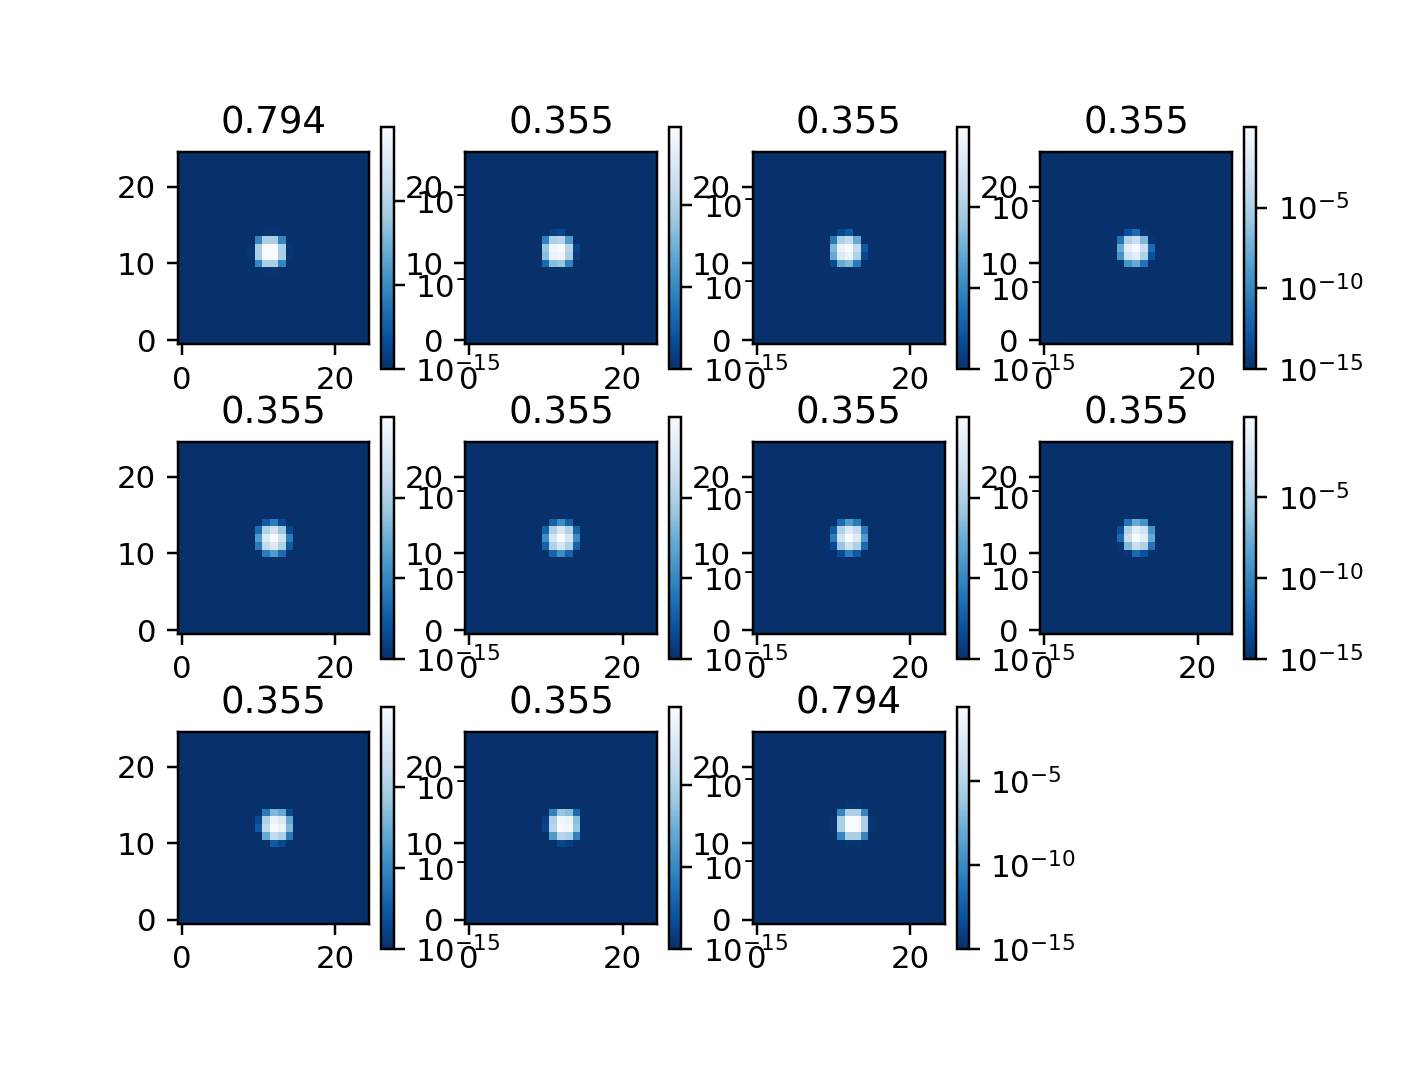

In [23]:
fig = plt.figure()
i = 1
for x in np.arange(-.5,.6,0.1):
    S = singleGaussian2d(x0im,y0im,x,x,sigma_x=0.3, sigma_y= 0.3)
    psfBox = geom.Box2I(geom.Point2I(-12, -12), geom.Point2I(12, 12))
    psf = afwImage.ImageD(psfBox)
    psf.array = S
    psfNew = afwMath.FixedKernel(psf)
    psfNew = measAlg.KernelPsf(psfNew)
    r = psfNew.computeShape().getDeterminantRadius()
    
    ax = fig.add_subplot(3,4,i)
    i += 1
    cs = ax.imshow(np.abs(S)+1e-15,origin='bottom',cmap='Blues_r',norm=matplotlib.colors.LogNorm())
    fig.colorbar(cs)
    ax.set_title(f'{r:.3f}')